In [1]:
import numpy as np
import h5py 
import matplotlib.pyplot as plt
import glob
import cloning_algorithm as ca

# Introduction

In this notebook we use the cloning algorithm to, from time series data, evaluate a survival probability and associated exit rate for a tube of finite radius around a reference path.


# Time series data

The time series data is generated using the python script *generate trajectories.py* in this example folder. Upon execution, the script creates a subfolder data/, where it stores the results of 20 independently generated sample time series. The script generates about 160 MB of data.

The time series are generated using a 1D overdamped Langevin model, with drift and diffusivity

\begin{align}
D(x) &= \frac{D_0}{4} \left[ 5 - \cos\left(\pi \frac{x}{L}\right)\right],
\\
a(x) &= -\partial_x U_a,
\\
U_a(x) &= a_0 \left[ \left( \frac{x}{L}\right)^2 - 1 \right]^2 - a_1 \frac{x}{L},
\end{align}

where $D_0 = L^2/T$, $a_0 = 2$, $a_1 = a_0/20$ and $L$, $T$ are a length- and time scale.

Since in the following we compare analyses of the numerical data to theoretical predictions, we define the diffusivity and drift as functions:

In [2]:
L = 1.
T = 1.
a0 = 2.
a1 = a0/20.
D0 = L**2/T

a = lambda x: a1/L \
            + 4*a0*x/L**2 \
            - 4*a0*x**3/L**4
D = lambda x: D0*( 5 - 1*np.cos(np.pi*x/L))/4.

# for later use we also define some spatial derivatives of a, D:
da_dx = lambda x: 4*a0/L**2 \
                - 12*a0*x**2/L**4
dD_dx = lambda x: D0*np.sin(np.pi*x/L)/4.*np.pi/L
ddD_dx = lambda x: D0*np.cos(np.pi*x/L)/4.*(np.pi/L)**2

 We emphasize that defining (or even knowing) the underlying drift and diffusivity of a Markovian time series is not necessary to use the cloning algorithm.

# Time series generator for cloning algorithm

To use the cloning algorithm, we need to define a time series generator, which for a given initial condition returns a short time series.

With the class in the next cell we implement a time series generator that uses given sample time series as follows: 

* First, we load the given sample time series are loaded into an instance of the class
* For a given binning of the spatial domain, we then index the sample time series; this allows us to randomly select a time series that starts within each bin
* To generate a trajectory starting at a point $x_0$, we first identify the bin in which $x_0$ is. Then we return a random sample time series that starts within this bin. (If the binning is sufficiently small, then in practice it is no problem that the given time series does not start exacly at $x_0$, but only in the same bin.)

In [3]:
class time_series_generator:
    '''
    This class returns a sample time series for given number of timesteps 
    and initial state
    '''

    def __init__(self,parameters):
        #
        #
        self.n_steps = parameters['n_steps'] # maximal length of trajectory
        # snippets. The time series we load should be longer than this.
        self.dt_data = parameters['dt_data'] # timestep of the data
        self.bin_edges = parameters['bin_edges']
        #
        self.bin_left = self.bin_edges[:-1]
        self.bin_right = self.bin_edges[1:]
        self.dx = self.bin_edges[1] - self.bin_edges[0]
        self.N_bins = len(self.bin_left)
        #

    def import_data(self,list_of_trajectories):
        #
        self.data = {}
        #
        for i,trajectory in enumerate(list_of_trajectories):
            self.data[i] = trajectory
        #
        return self.data

    def load_data_single_file(self,filename):
        #
        output_dictionary = {}
        #
        with h5py.File(filename, 'r') as hf:
            for key, value in hf.items():
                output_dictionary[key] = value[()]
        #
        return output_dictionary

    def load_data(self,filenames):
        #
        self.data = {}
        #
        for i,filename in enumerate(filenames):
            #
            current_data = self.load_data_single_file(filename=filename)
            #
            self.data[i] = current_data['x']
            #
        #
        return self.data

    def get_histogram(self):
        #
        hist = None
        #
        for x in self.data.values():
            #
            hist_, bin_edges =  np.histogram(x,bins=self.bin_edges,
                                                density=False)
            #
            if hist is None:
                hist = hist_
            else:
                hist += hist_ 
        # 
        bin_centers = (bin_edges[1:] + bin_edges[:-1])/2.
        bin_width = bin_edges[1] - bin_edges[0]
        #
        output_dictionary = {'bin_centers':bin_centers,
                            'bin_edges':bin_edges,
                            'bin_width':bin_width,
                            'hist':hist}
        #
        return output_dictionary

    def get_bin_indices(self,x):
        #
        if len(x) < self.n_steps:
            return np.array([])
        #
        x = x[:-self.n_steps]
        #
        indices = np.array((x-self.bin_left[0])//self.dx,
                            dtype=int)
        return indices

    def create_index(self):
        #
        traj_number = np.array([],dtype=int)
        traj_index = np.array([],dtype=int)
        traj_bin_index = np.array([],dtype=int)
        #
        for i,x in self.data.items():
            #
            cur_indices = self.get_bin_indices(x=x)
            #
            #if i == 0:
            #    print(cur_indices[:10])
            traj_number = np.append(traj_number,
                np.ones(len(cur_indices))*i) # index of current trajectory
            traj_index = np.append(traj_index,
                np.arange(len(cur_indices))) # index within current trajectory
            traj_bin_index = np.append(traj_bin_index,
                cur_indices) # index of bins
            #
        #
        list_of_bin_indices = []
        for i in range(self.N_bins):
            list_of_bin_indices.append(
                        np.array(np.where(traj_bin_index == i)[0],dtype=int)
                                )
        #
        self.traj_number = traj_number
        self.traj_index = traj_index
        self.traj_bin_indices = list_of_bin_indices
        #
        return traj_number ,traj_index, list_of_bin_indices

    def get_time_series(self,x0,t0=0.):
        #
        try:
            x0_scalar = x0[0]
        except TypeError:
            x0_scalar = x0
        except IndexError:
            x0_scalar = x0
        #
        # need to identify the bin of the current position,
        # and draw a random trajectory from that bin
        bin_index = int((x0_scalar-self.bin_left[0])//self.dx)
        #
        index = np.random.choice(self.traj_bin_indices[bin_index])
        trajectory_index = self.traj_number[index]
        time_index = self.traj_index[index]
        #
        trajectory = self.data[trajectory_index]
        trajectory = trajectory[time_index:time_index + self.n_steps+1]
        #
        return trajectory.reshape([self.n_steps+1,1])

In [4]:
# We now create an instance of the time series generator class

dt_data = 5e-5 # timestep of recorded time series, in units of T
n_steps = 200 # number of steps per iteration in cloning algorithm
DT = dt_data*n_steps # time per iteration in cloning algorithm
print('DT =',DT)
bin_edges = np.linspace(-1.5,1.5,num=150,endpoint=True) # binning, which should
# fulfill two conditions:
# * The time series samples should have data in any bin
# * The tubes considered below in the condition_detector should never extend
#   beyond the bins (i.e. here below -1.5 or 1.5)

parameters = {'bin_edges':bin_edges,
'n_steps':n_steps,
'dt_data':dt_data}

tsg = time_series_generator(parameters=parameters)

DT = 0.01


In [5]:
# We load the sample time series into our time series generator instance
files = glob.glob('sample_data/*.h5')

tsg.load_data(filenames=files);

# Potential profile

We bin the recorded time series to get an approximate steady-state distribution. Boltzmann inversion of that steady-state distribution then yields a potential profile.

We compare this potential profile to the theoretical expectation for a Langevin model with the parameters used for the simulation:

dx/L = 0.020134228187919545


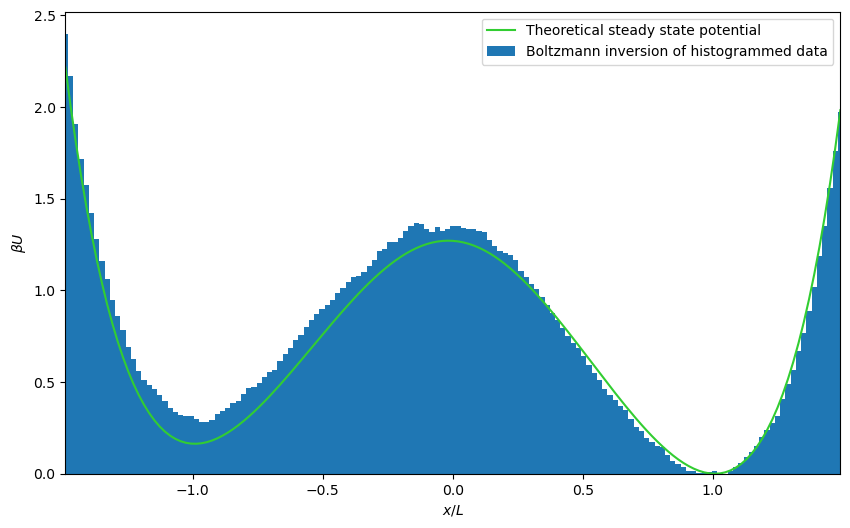

In [6]:
histogram_data = tsg.get_histogram()

x = histogram_data['bin_centers']
dx = histogram_data['bin_width']
hist = histogram_data['hist']
U_data = -np.log(hist)
U_data -= np.min(U_data)
print('dx/L =',dx)

# We evaluate the steady state

a_ = a(x)
D_ = D(x)

from scipy.integrate import cumtrapz

U = -cumtrapz(y=a_/D_,
            x=x,
            initial=0) + np.log(D_)

U -= np.min(U)

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.bar(x,U_data,dx,
            label='Boltzmann inversion of histogrammed data')
ax.plot(x,U,color='limegreen',
            label='Theoretical steady state potential')
ax.set_xlabel(r'$x/L$')
ax.set_ylabel(r'$\beta U$')
ax.set_xlim(np.min(x),np.max(x))
ax.legend(loc='best')

plt.show()
plt.close(fig)

The deviations are because the time series we generated are relatively short, so that the binned time series distribution has not yet converged to the steady state distribution. 

If one were to generate time series that are considerably longer (e.g. 10 or 100 times as long), then the agreement will be better. However, this will take more time and hard drive space.

In [7]:
# Before running the cloning algorithm, the time series generator needs
# to create an index (which contains the information which trajectory is 
# in which bin at which time)
tsg.create_index();

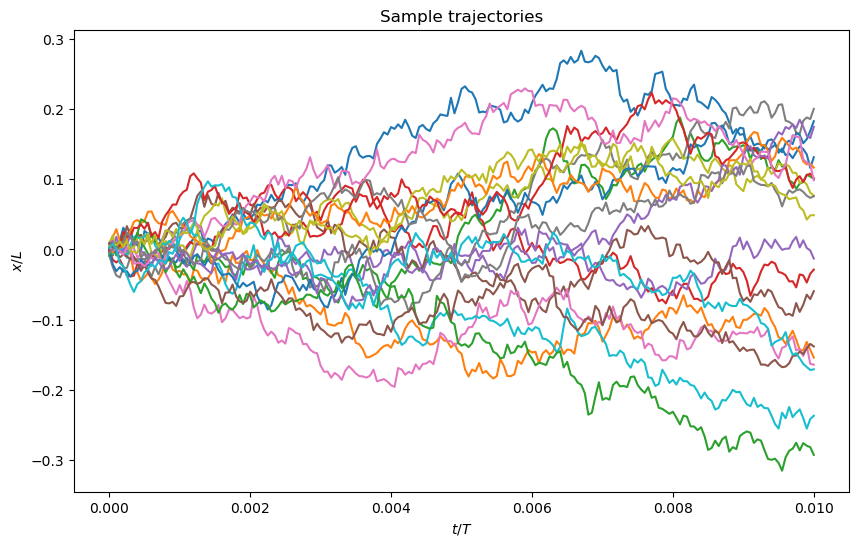

In [8]:
# plot some sample trajectories starting at the origin
fig, ax = plt.subplots(1,1,figsize=(10,6))

for i in range(20):
    x = tsg.get_time_series(x0=0.)
    t = np.arange(len(x))*dt_data
    ax.plot(t,x)

ax.set_title('Sample trajectories')
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$x/L$')
plt.show()
plt.close(fig)

# Condition detector

For the reference path

\begin{align}
\varphi(t) = \frac{ x_L + x_R}{2}
+ \frac{ x_R - x_L}{2} \frac{\arctan\left( \kappa (t/t_f-1/2)\right)}{\arctan(\kappa/2)},
\end{align}

we consider the ensemble of trajectories that starts at $t=0$ at $X_0 = \varphi(0)$, and
always remains within distance $R$ of $\varphi(t)$. The probability
to observe a sample trajectory that fulfills this condition up to time $t_f$ is 
called the sojourn probability 
\begin{align}
P_R^{\varphi}(t_f) &= P(\,|X_t - \varphi(t)| < R\quad \forall t \in [0, t_f] \mid X_0 = 0 \,),
\end{align}
where by writing $P_R^{\varphi}(t_f)$ we omit the dependence of the sojourn probability
on the initial condition.
For this particular rare event, where a stochastic trajectory remains close to 
a given reference path, we use the names "sojourn probability" and "survival probability"
interchangeably.

In [9]:
class condition_detector:
    '''
    This class has a method called "evaluate_condition", which takes a time
    series and returns the array index at which the time series stops 
    fulfilling the desired condition
    '''

    def __init__(self,parameters):
        #
        self.R = parameters['R']
        #

    def set_path(self,path):
        #
        self.x_func = path

    def evaluate_condition(self,x,t):
        '''
        Evaluate the condition on a given time series
        '''
        #
        path = self.x_func(t).reshape([len(t),1])
        #
        distance_from_path = np.fabs( x - path  )
        mask = (distance_from_path > self.R)
        #
        if mask[0]:
            return 0
        #
        leaving_index = np.argmax(mask)
        #
        if leaving_index == 0:
            leaving_index = -1
        #
        return leaving_index

    def evaluate_observables(self,results):
        '''
        Here you can implement any observable that you are interested in.

        We here implement the mean and standard deviation of the survivors.
        Furthermore, we collect the final distribution of survivors at the
        end of each iteration.
        '''
        #
        # get all relevant data from input dictionary
        t = results['t']
        x = results['x']
        leaving_indices = results['leaving_index']
        n_steps = len(t)
        #
        # at each timestep, calculate mean and standard deviation of 
        # distribution of surviving time series 
        mean = np.zeros(n_steps,dtype=float)
        std = np.zeros(n_steps,dtype=float)
        for i in range(n_steps):
            mask = (leaving_indices > i+1) | (leaving_indices == -1)
            survivors = x[mask,i]
            #
            mean[i] = np.mean(survivors)
            std[i] = np.std(survivors)
        #
        # at the end of each iteration, calculate the distribution of the
        # final states of all surviving time series
        mask = (leaving_indices == -1)
        hist, bin_edges = np.histogram(x[mask,-1,0],bins=100,density=True)
        hist = hist.reshape([1,len(hist)])
        bin_edges = bin_edges.reshape([1,len(bin_edges)])
        t_hist = np.array([t[-1]])
        #
        # return dictionary with all observables
        observables = {'mean':mean,
                        'std':std,
                        'hist':hist,
                        'bin_edges':bin_edges,
                        't_hist':t_hist,
                        }
        #
        return observables


In [10]:
# Create an instance of our condition_detector

R = .3 # tube radius in units of L

parameters_detector = {'R':R}
detector = condition_detector(parameters_detector)

# note that the reference path will be passed to our instance of the
# condition_detector in the next cell

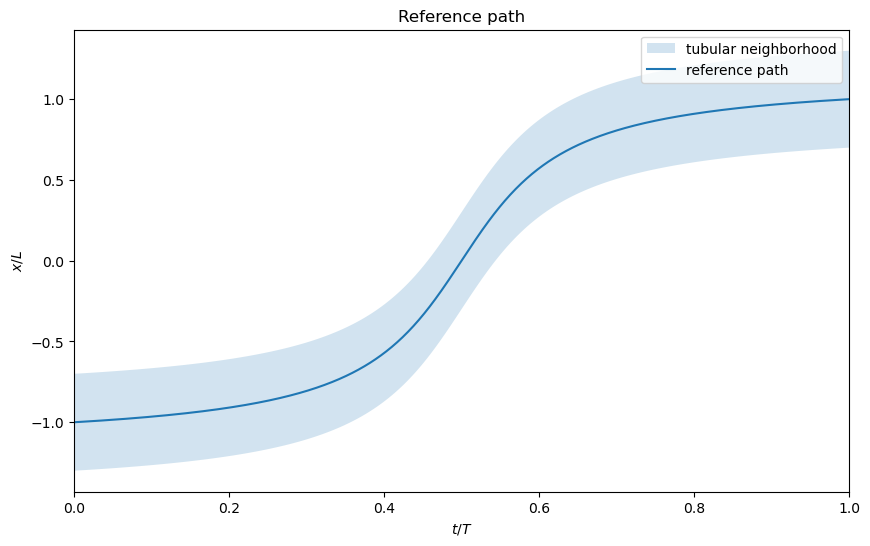

In [11]:
# Define the reference path
xL = -1.
xR =  1.
k = 10.
path = lambda t: (xL+xR)/2. + (xR-xL)/2./np.arctan(k/2)*np.arctan(k*(t-0.5))

t_f = 1. # total duration of path in units of T

# Set the path in the condition_detector
detector.set_path(path=path)

# plot the path
t = np.linspace(0,t_f,num=1001,endpoint=True)

fig,ax  = plt.subplots(1,1,figsize=(10,6))
ax.set_title('Reference path')
ax.fill_between(t,path(t)-R,path(t)+R,
            alpha=0.2,label='tubular neighborhood')
ax.plot(t,path(t),
            label='reference path')
ax.set_xlabel(r'$t/T$')
ax.set_ylabel(r'$x/L$')
ax.set_xlim(np.min(t),np.max(t))
ax.legend(loc='best')
plt.show()
plt.close(fig)

# Cloning algorithm


We now use the cloning algorithm to infer the sojourn probability $P_R^{\varphi}(t)$ ($t \in [0,t_f]$)
and its associated instantaneous exit rate
\begin{align}
\alpha_{R}^{\varphi}(t) := -\frac{\partial_t P_R^{\varphi}(t)}{P_R^{\varphi}(t)}.
\end{align}

In [12]:
# parameters for the cloning algorithm
n_iterations = int(t_f/DT) # number of iterations
print('n_iterations =',n_iterations)
print('n_steps =',n_steps)
print('Consistency check: n_steps * n_iterations * dt_data =',
            n_iterations * n_steps * dt_data)
print('( Previous line should yield the value t_f =',t_f,')')
#
n_clones = 10000 # number of time series generated in first iteration
n_target = 2000 # target for time series surviving until the end of each
               #  iteration
n_clones_max = 10000 # maximal number of time series per iteration
n_cores = 2 # number of cores

verbose=True # output progress

t0 = 0.
x0 = [path(0)] 

parameters = {'t0':t0,
                'dt':dt_data,
                #
                'n_steps':n_steps,
                'n_iterations':n_iterations,
                'n_clones':n_clones,
                'n_cores':n_cores,
                'initial_conditions':x0,
                'n_target':n_target,
                'n_clones_max':n_clones_max,
                'verbose':verbose}

clone = ca.cloning_algorithm(parameters=parameters,
            time_series_generator=tsg,
            condition_detector=detector
            )

n_iterations = 100
n_steps = 200
Consistency check: n_steps * n_iterations * dt_data = 1.0
( Previous line should yield the value t_f = 1.0 )


# Evaluate the sojourn probability (and exit rate) using the cloning algorithm

In [13]:
results = clone.run(filename='cloning_from_recorded_time_series.h5')

Finished all 100 interations. Mean number of clones used: 3143.53.                 


In [14]:
# Content of the output dictionary of cloning_algorithm.run():
print('results.keys() =',results.keys())
# In particular:
print("results['observables'].keys() =",results['observables'].keys())

results.keys() = dict_keys(['t', 'remainers', 'survival_probability', 'exit_rate', 'n_clones', 'final_positions', 'observables', 'parameters'])
results['observables'].keys() = dict_keys(['mean', 'std', 'hist', 'bin_edges', 't_hist'])


# Compare the inferred exit rate to analytical predictions

In [15]:
# We also plot a smoothed version of the exit rate
def smooth_time_series(x,N=200):
        ''' from https://stackoverflow.com/a/33585850 '''
        idx = np.arange(N) + np.arange(len(x)-N+1)[:,None]
        return np.mean(x[idx],axis=1)

def plot(data):
        fig, ax = plt.subplots(1,1,figsize=(10,6))
        fig.suptitle(data['suptitle'])
        for i,e in enumerate(data['time_series']):
                ax.plot(e[0],e[1],
                        label=e[2],ls=e[3],color=e[4],
                        lw=2)
        try:
                if data['ylog']: ax.set_yscale('log')
        except KeyError:
                pass
        ax.set_xlabel(data['xlabel'])
        ax.set_ylabel(data['ylabel'])
        try:
                if data['legend']: ax.legend(loc='best')
        except KeyError:
                pass
        #ax.set_xlabel()
        #ax.set_ylabel()
        plt.show()
        plt.close(fig)

def exit_rate_theory(p,t):
    #
    D_ = D(p)
    a_ = a(p)
    da_ = da_dx(p)
    dD_ = dD_dx(p)
    ddD_ = ddD_dx(p)
    #
    # time derivative of path
    dp_dt = np.zeros_like(p,dtype=float)
    dp_dt[0] = (p[1] - p[0])/(t[1] - t[0])
    dp_dt[1:-1] = (p[2:] - p[:-2])/(t[2:] - t[:-2])
    dp_dt[-1] = (p[-1] - p[-2])/(t[-1] - t[-2])
    #
    afree = D_*np.pi**2/(4*R**2)
    #
    L0 = (dp_dt - a_ + dD_)**2/(4*D_) + da_/2. \
            - (np.pi**2-1)/16. * dD_**2/D_ \
            + (np.pi**2/6 - 1)/4 * ddD_
    return afree, L0

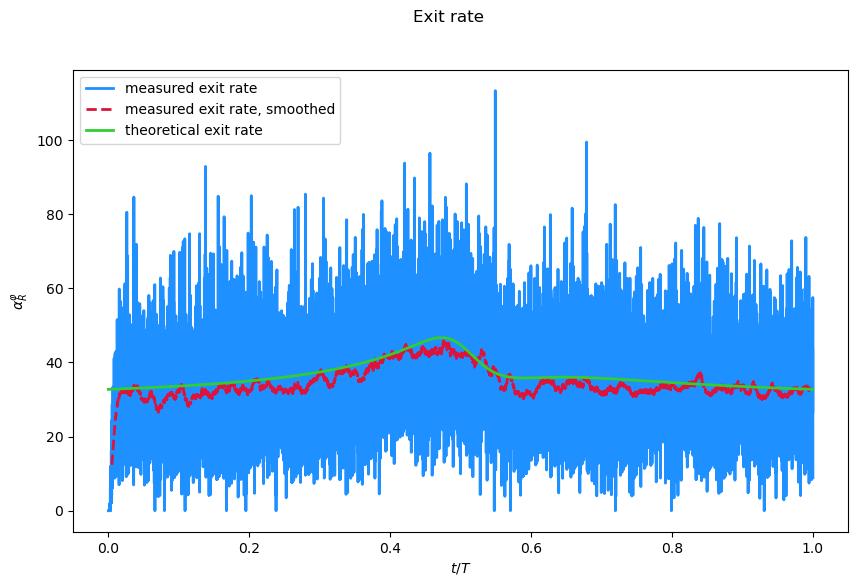

In [16]:
# the output dictionary from cloning_algorithm.run() contains, among others,
# the exit rate and survival probability as a function of time: 
t = results['t']
exit_rate = results['exit_rate']

exit_rate_smoothed = smooth_time_series(exit_rate)
t_smoothed = smooth_time_series(t)

# Evaluate analytical prediction for exit rate
afree, L0 = exit_rate_theory(path(t),t)
a_theory = afree + L0


data_exit_rate = {'suptitle':"Exit rate",
'xlabel':r'$t/T$',
'ylabel':r'$\alpha_R^{\varphi}$',
'time_series':[[t,exit_rate,'measured exit rate','-',
                        'dodgerblue'],
        [t_smoothed,exit_rate_smoothed,'measured exit rate, smoothed','--',
                        'crimson'],
        [t,a_theory,'theoretical exit rate','-',
                        'limegreen']],
'legend':True
}

plot(data=data_exit_rate)

We observe that the theoretical exit rate agrees reasonably well with the smoothed
measured exit rate. As discussed in the manuscript [update reference to arXiv once paper is there], the inferred exit rate slightly underestimates the true (i.e. here the theoretical) exit rate.